In [13]:
from rsa import ExtendedEuclideanAlgorithm, SquareAndMultiply, MillerRabin, RSA
from rsa import ProbabilityToBePrime
import random
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import matplotlib.pyplot as plt


# Asymmetric Ciphers

**Asymmetric Ciphers** are cryptographic algorithms that use different keys, called respectively **public and private keys**, for encryption and decryption. This property solves one of the main issues of symmetric ciphers, that was the necessity of a secure channel to share the unique key among Alice and Bob. The entire process follows this scheme:
- Bob generates both the public and the private key
- Bob sends to Alice the private key over a **potentially unsecure channel**, meaning that the public key may be "stolen" by an attacker
- Alice uses the public key to encrypt the plaintext and sends the obtained ciphertext to Bob
- Bob uses the private key to decrypt the ciphertext

The reason why everything works fine is in the definiton of the encryption and decryption function: a part from being one the inverse of the other, they are based on what is called **One Way Function**: it is easy to compute in one direction and complex in the opposite one, unless some specific informations are known. In the case of asymmetric ciphers, these informations are in the private key so that knowing the public key is not sufficient for an attacker to decrypt the ciphertext.

Typically asymmetric ciphers are more expensive than stream or block ciphers: this is why they are used for the key exchange process of symmetric ciphers, in order to pay the cost of the asymmetric cipher only once and then use the symmetric one to send the real message.

This notebook will focus on RSA, one of the most used asymettric ciphers, and on the algorithms involved in it. Subsequently, a possible application of RSA will be implemented coupling it with AES. Eventually Monte Carlo method will be used to estimate the probability that a very large random number is prime, that is a key aspect of RSA.

## RSA

**RSA** is one of the most used asymmetric ciphers. Unlike stream and block ciphers that we have seen so far, RSA works with integer numbers and not with bit/bytes or text. RSA functioning is described below:
- Bob generates to large prime numbers $p$ and $q$ and computes $n = p \cdot q$
- Bob computes $m = \phi(n) = (p-1)\cdot(q-1)$, called **totient of n**, that counts how many positive integers smaller than $n$ are coprime with it
- Bob computes $e$ and $d$ so that $gcd(e, m) = 1$ and $ed \equiv 1  (\textrm{mod}\ m)$ ($d$ is called **modular inverse of $e$ modulo m**)
- Bob builds the public key as $(n, e)$ and the private key as $(n, d)$
- Bob sends the public key to Alice
- Alice encrypts the plaintext, previously converted into an integer number $x$, computing $y = x^e \backslash n$ and sends the ciphertext $y$ to Bob
- Bob decrypts the ciphertext doing $x = y^d \backslash n$

If an attacker has the public key $(n, e)$ he needs to compute $m$ and then $d$ to decrpyt the ciphertext. It seems that, once $n$ is known, computing $m$ is easy: in reality $\phi(n)$ can be simply computed only if the factors of $n$ are known but it is extremely complex if they are not. To obtain them, an attacker needs to factorize $n$, that in modern RSA implementations is typically 1024, 2048 or 4096 bits, and this is considered computationally unfeasible. All this constitues the One-Way function employed in RSA.

In the following steps we will focus on the algorithms used for the keys generation and encryption and decryption functions.

### Miller Rabin Primality Test

In [14]:
# Prime number
n = 6701531651
isprime = MillerRabin(n, 1000)
if isprime:
    print(f'{n} is probably a prime number')
else:
    print(f'{n} is not a prime number')

# Prime number
n = 1962443363
isprime = MillerRabin(n, 1000)
if isprime:
    print(f'{n} is probably a prime number')
else:
    print(f'{n} is not a prime number') 

# Composite number
n = 7863985485
isprime = MillerRabin(n, 1000)
if isprime:
    print(f'{n} is probably a prime number')
else:
    print(f'{n} is not a prime number')

# Composite number = product of 3 big prime numbers
n = 735495555426839*587000395258763*374906457293939
isprime = MillerRabin(n, 1000)
if isprime:
    print(f'{n} is probably a prime number')
else:
    print(f'{n} is not a prime number')



6701531651 is probably a prime number
1962443363 is probably a prime number
7863985485 is not a prime number
161860682384236698774917023853734785426608423 is not a prime number


### Extended Euclidean Algorithm

In [15]:
a = 39
m = 60
gcd, s, t = ExtendedEuclideanAlgorithm(a, m)
print(f'The GCD of {a} and {m} is {gcd}')
print(f's = {int(s)} and t = {int(t)} are the values so that sa + tm = gcd(a, m),'\
        f' indeed {int(s)}*{a} + {int(t)}*{m} = {gcd}\n')

a = 2560945
m = 98714510
gcd, s, t = ExtendedEuclideanAlgorithm(a, m)
print(f'The GCD of {a} and {m} is {gcd}')
print(f's = {int(s)} and t = {int(t)} are the values so that sa + tm = gcd(a, m),'\
        f' indeed ({int(s)}*{a}) + ({int(t)}*{m}) = {gcd}\n')

# Particular cases
a = 0
m = 2560945
gcd, s, t = ExtendedEuclideanAlgorithm(a, m)
print(f'The GCD of {a} and {m} is {gcd}')
print(f's = {int(s)} and t = {int(t)} are the values so that sa + tm = gcd(a, m),'\
        f' indeed ({int(s)}*{a}) + ({int(t)}*{m}) = {gcd}\n')

a = 25
m = 25
gcd, s, t = ExtendedEuclideanAlgorithm(a, m)
print(f'The GCD of {a} and {m} is {gcd}')
print(f's = {int(s)} and t = {int(t)} are the values so that sa + tm = gcd(a, m),'\
        f' indeed ({int(s)}*{a}) + ({int(t)}*{m}) = {gcd}')


The GCD of 39 and 60 is 3
s = -3 and t = 2 are the values so that sa + tm = gcd(a, m), indeed -3*39 + 2*60 = 3

The GCD of 2560945 and 98714510 is 5
s = 4135267 and t = -107281 are the values so that sa + tm = gcd(a, m), indeed (4135267*2560945) + (-107281*98714510) = 5

The GCD of 0 and 2560945 is 2560945
s = 0 and t = 1 are the values so that sa + tm = gcd(a, m), indeed (0*0) + (1*2560945) = 2560945

The GCD of 25 and 25 is 25
s = 1 and t = 0 are the values so that sa + tm = gcd(a, m), indeed (1*25) + (0*25) = 25


### Square and Multiply

In [16]:
base = 4
exp = 5
mod = 35
y = SquareAndMultiply(base, exp, mod)
print(f'x^e \\ n = {y}')

x^e \ n = 9


### RSA implementation testing

In [17]:
##### Testing of the RSA class #####

# Inside the class the instructions in the DEBUG branches are executed
# Then p and q are equal to 335895919357171 and 744053548667773 respectively
bob = RSA(debug = True)
alice = RSA(n = bob.pub_key[0], e = bob.pub_key[1], debug = True)

# To simplify the debug process integers are used instead of bytes
plaintext = 3223675867980
print(f'\nThe plaintext is: {plaintext}')
ciphertext = alice.encrypt(plaintext)
print(f'The ciphertext is: {ciphertext}')
dec_plaintext = bob.decrypt(ciphertext)
print(f'The decrypted plaintext is: {dec_plaintext}')

# Full testing with random p and q and key length equal to 512 bits and
# bytes format for plaintext and ciphertext
bob = RSA(length = 512)
alice = RSA(n = bob.pub_key[0], e = bob.pub_key[1])
plaintext = random.randbytes(20)
print(f'\nThe plaintext is: {plaintext}')
ciphertext = alice.encrypt(plaintext)
print(f'The ciphertext is: {ciphertext}')
dec_plaintext = bob.decrypt(ciphertext)
print(f'The decrypted plaintext is: {dec_plaintext}')
 


The plaintext is: 3223675867980
The ciphertext is: 64091386761571093932794909611
The decrypted plaintext is: 3223675867980

The plaintext is: b',\x9d\xe3\x04%\x88\xcc\x1d>\x05\x82qD-\x8c\xa6-\xd8=Q'
The ciphertext is: b"Y|\x97\xaf\x82\x9f\x17\xc6\xd9\\\xe5\xcf\xd6$\xeb\xb0\x0f8f\xaa\xc4\xea\x1eZ\x8c_'\x8d*3\xbd\x0c\x90>\xc8\x86\x90\xc629\x87~+~k\x8ac\xc1\x17\x19\xd4\x16\xf7/+\xc9\xc8K\xbft\xbc\xb3\xed\xb6"
The decrypted plaintext is: b',\x9d\xe3\x04%\x88\xcc\x1d>\x05\x82qD-\x8c\xa6-\xd8=Q'


In [18]:
# The plaintext is chosen so that it longer than the key length. For this reason
# it cannot be encrypted. Let's see if an error is raised...
bob = RSA(length = 20)
print(bob.pub_key)
print(bob.priv_key)
alice = RSA(n = bob.pub_key[0], e = bob.pub_key[1])
plaintext = random.randbytes(30)
print(f'\nThe plaintext is: {plaintext}')
try:
    ciphertext = alice.encrypt(plaintext)
    print(f'The ciphertext is: {ciphertext}')
    dec_plaintext = bob.decrypt(ciphertext)
    print(f'The decrypted plaintext is: {dec_plaintext}')
except ValueError as e:
    print(e)

(657023, 5)
(657023, 393221)

The plaintext is: b'lAk\xbf\xc6\xbb\xa4\xf9\xe28\x93~\xe6\x98F\x8a\xdd\xed(g\x07\xe1qH\xb6\xc0$9\xdf\x91'
ERROR -> the plaintext to encrypt is too long. Try with a shorter one.


### RSA and AES

In [19]:
with open('lorem_ipsum.txt', 'r') as f:
    aes_plaintext = f.read()
print(aes_plaintext[:70] + ' ...')

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmo ...


In [20]:
# AES.key_size is the list [16, 24, 32]. We select the third as
# key length (256 bits)

alice_aes_key = random.randbytes(AES.key_size[2])
iv = random.randbytes(16)
bob_rsa = RSA(length = 512)
alice_rsa = RSA(n = bob_rsa.pub_key[0], e = bob_rsa.pub_key[1])
bob_aes_key = bob_rsa.decrypt(alice_rsa.encrypt(alice_aes_key))
alice_aes = AES.new(alice_aes_key, AES.MODE_CBC, iv)
bob_aes = AES.new(bob_aes_key, AES.MODE_CBC, iv)
padded_aes_plaintext = pad(aes_plaintext.encode(), AES.block_size)
aes_ciphertext = alice_aes.encrypt(pad(aes_plaintext.encode(), AES.block_size))
dec_aes_plaintext = (unpad(bob_aes.decrypt(aes_ciphertext), AES.block_size)).decode()
if aes_plaintext == dec_aes_plaintext:
    print('Everything worked fine. Great job!')
    print(f'The decrypted plaintext is:\n{dec_aes_plaintext[:70]} ...')
else:
    print('Something went wrong. Check your implementation')


Everything worked fine. Great job!
The decrypted plaintext is:
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmo ...


### Probability that a large random number is prime

The RSA key generation requires two very large prime numbers p and q. These are obtained by drawing some random numbers of $\frac{L}{2}$ bits (L is the key length) and checking whether they are prime using the Miller Rabin Test. Depeding on the required key length (typical values for RSA are 512, 1024 or 2048 bits) the probability that such big numbers end up to be prime is very low and the larger they are the lower is the probabiltiy.

...........
rel diff: inf
rel diff: 0.3076923076923078
rel diff: 0.1470588235294117
rel diff: 0.06410256410256417
rel diff: 0.030120481927710867
...........
rel diff: inf
rel diff: 1.3333333333333333
rel diff: 0.21428571428571436
rel diff: 0.17647058823529405
rel diff: 0.04375000000000004


KeyboardInterrupt: 

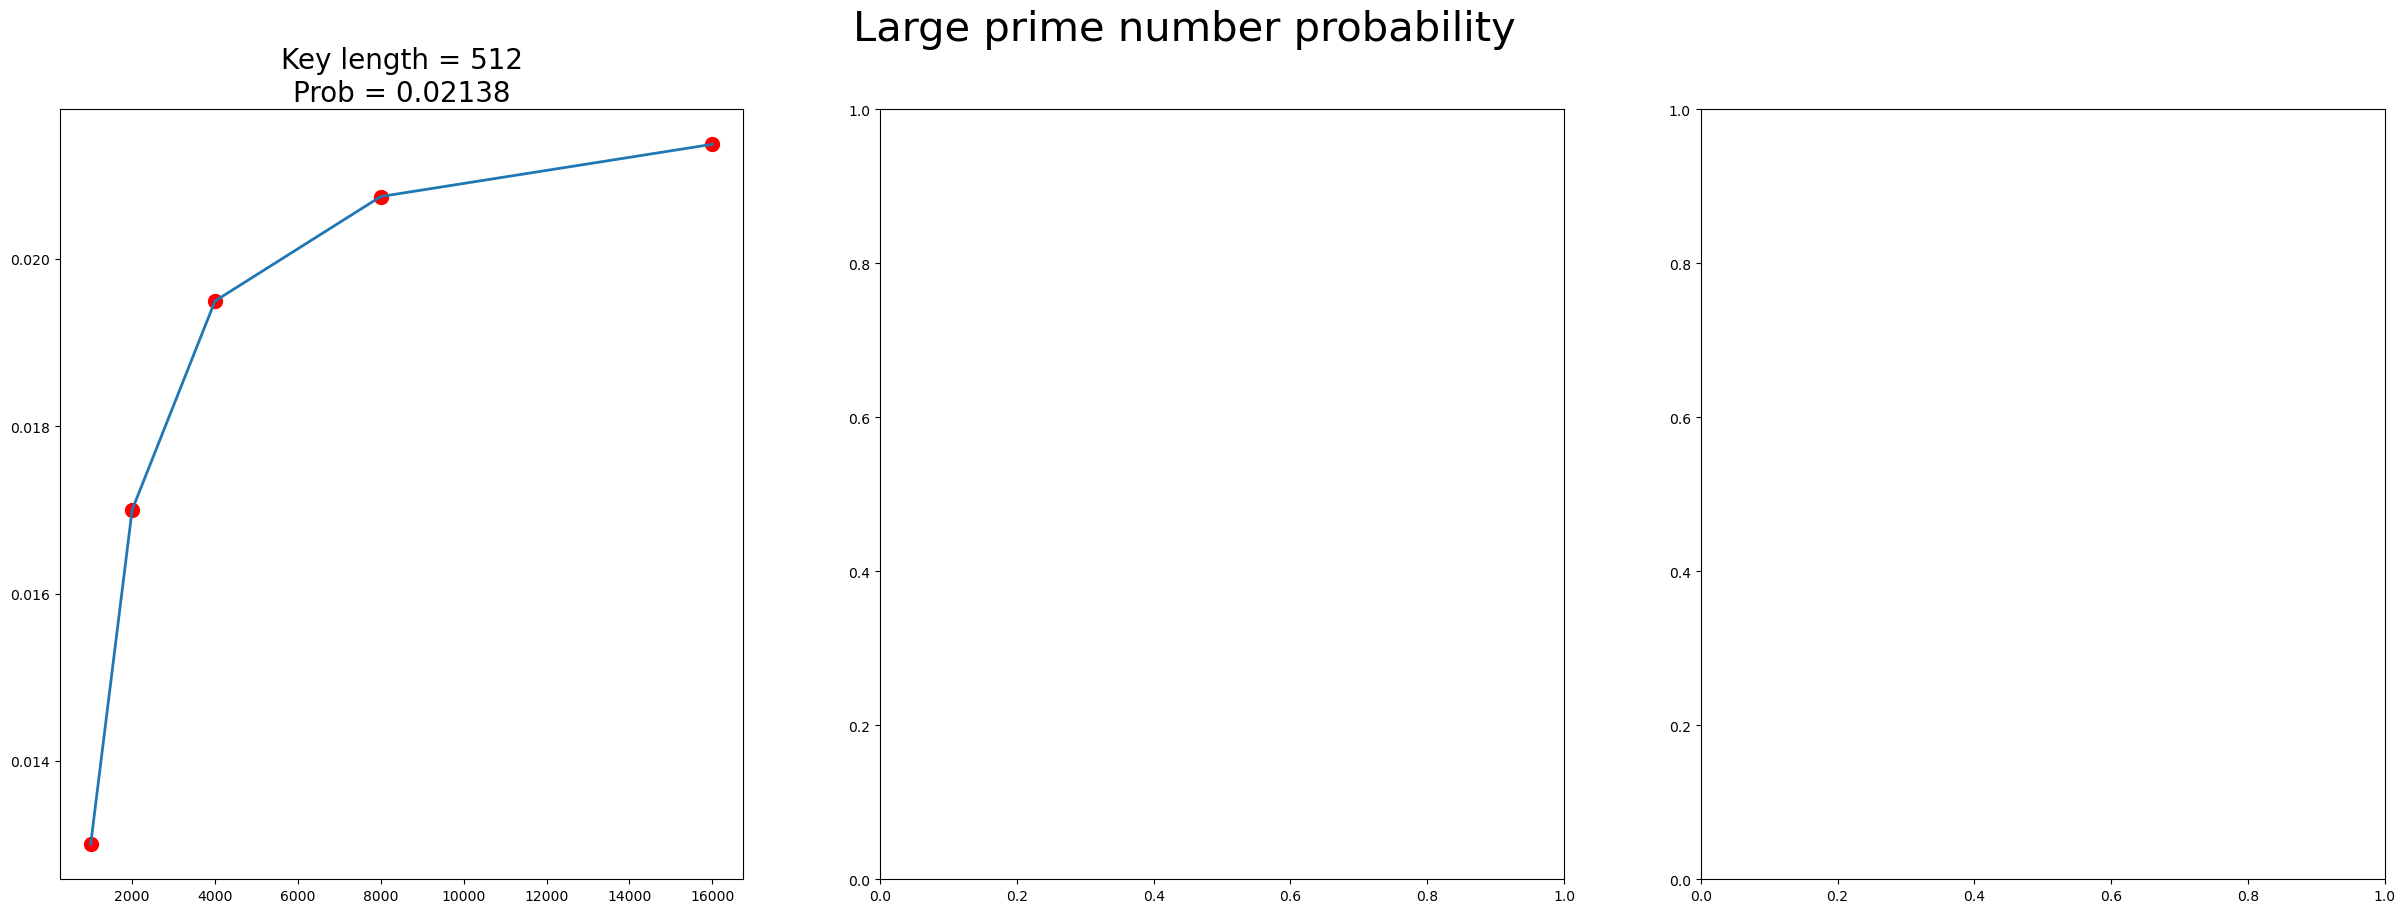

In [23]:
key_lengths = [512, 1024, 2048]
fig, axs = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Large prime number probability', fontsize=30)
for idx, length in enumerate(key_lengths):
    print('...........')
    est, prob = ProbabilityToBePrime(length, 0.1, 1000, 128000)
    axs[idx].plot(list(est.keys()), list(est.values()), linewidth=2)
    axs[idx].scatter(list(est.keys()), list(est.values()), color='r', s=100)
    axs[idx].set_title(f'Key length = {length}\nProb = {prob:.5f}', fontsize=20)


## Conclusions

 ## References